#   File: DSC550 Curry Week8 MidTerm.py
#   Name: Adam Curry
#   Date: 04/30/2020
#   Course: DSC540 - Data Mining
#   Desc: This program conducts a topic model on Tweets made by @realDonaldTrump. There is no political motives, I just thought it'd be fun to show the president's Tweets over time
#   Usage: This program should be used when reviewing my midterm

The goal of this project is to analyze Tweets from the president. There are no political motives and there are no assumptions made about the president. With that disclaimer, below are some hypothesis questions I’d like to answer.

*    Does the president have more tweets before he was president (<201611) or after (>201611)?
*   What topic did the president tweet about the most and is this topic consistent over time?
*   Are there any correlations between the topic and the time of year?
*   Are there any correlations between the topic and the number of retweets and favorites?
    * Retweets – somebody retweets the president’s original tweet
    * Favorites – somebody “favorited” (liked) the president’s original tweet
*   Is there a linear trajectory of the frequency of retweets and favorites over time?
*   Is it possible to determine if President Trump was President at the time of the tweet, based on the topic itself?

Again, there are no political motives for this analysis. It will simply be interesting to apply several subjects learned form this course to unstructured data. These steps include:

1.    Loading a csv to data frame.
*    Cleaning the text data:
        * Remove punctuation
        * Lower case the text
        * Remove anything after @ and # as it’ll be one word and not overly useful
        * Apply stemming and lemmatization
*    Vectorize the text with TF-IDF
*    Add the topics back to the data frame
*    Check the dimensionality of the data frame
*    View the distribution with histograms
*    See how the data looks over time (Tweets over time)
*    Review correlation, specifically with topics
*    Use Parallel coordinates to see the relationship between the features.
*    Use a percentile feature selection model to find the most relevant features.
*    Transform the data that are right skewed to a logarithmic scale utilizing np.log1p. Print the features before and after to show their descriptive statistics
*    Converting categorical data to one hot encoding was completed between steps 7 and 8 where I converted the topics to a binary classifier.  
*	 Training - Split your data into two sets:  Training and Testing.
*	 Evaluation of prediction of whether a Tweet was made prior to or during Trump's presidency using logistic regression.
        * Metrics for the evaluation:  
        * Confusion Matrix - notice how well the model did with all features included. 
        * Precision, Recall & F1 score - all three scores were very high 93+
        * ROC curve - the curve is nearly perfect in predictions.
*    I decided to add an additional classifier to see if I could predict Trump's tweets by topic alone. This method wasn't as accurate, but still showed that the topics could make strong predictions on whether Trump was president or not. The F1 score was .73 and .67 respectively. Which means the topics he Tweets about can help to predict a timeline of his Tweets.

#### Step 1: import the data, clean, and apply stemming and lemmatization

In [1]:
import nltk
import pandas as pd

# import the covid comments
path =r'C:\Users\adamp\OneDrive\Desktop\a_data_mining\Week6\tweets.csv'
df = pd.read_csv(path,  engine='python')
#df =  pd.DataFrame(dataframe['text'].copy())
# remove hyper links from data
df['content_cleanLinks'] = df['text'].replace(
        r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
# remove hastags links from data
df['contents_hashtags'] = df['content_cleanLinks'].replace(
        r'http\S+', '', regex=True).replace(r'#.*?(?=\s|$)', '', regex=True)
# remove Tweets @ anybody
df['contents_at'] = df['contents_hashtags'].replace(
        r'http\S+', '', regex=True).replace(r'@.*?(?=\s|$)', '', regex=True)
import string
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')

def remove_punctuations(text):
    """
    remove punct and apply stemming and lower case all text
    """
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '').lower()
        stemmer.stem(text)
    return text

df = pd.DataFrame(df)
df['content_no_punk'] = df['contents_at'].apply(remove_punctuations)

# apply lemmatization
from nltk.corpus import wordnet

# add the models to an object
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    """
    apply part of speech tagging
    """
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    """
    apply part of speech tagging
    """
    global wordnet_tagged
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

# Lemmatizing
df['Lemmatized'] = df['content_no_punk'].apply(lambda x: lemmatize_sentence(x))
df = df[df['Lemmatized'].apply(lambda x: len(x) > 10)]
print(df.head())

               source                                               text  \
0  Twitter for iPhone  An incompetent political hack! Come back to Wa...   
1  Twitter for iPhone  This is a disgraceful situation! https://t.co/...   
2  Twitter for iPhone  Lamestream Media is only getting worse! https:...   
3  Twitter for iPhone           Cut him off now! https://t.co/kdGybEFeOI   
4  Twitter for iPhone  Great book. Get it and support Charlie! https:...   

       created_at  retweet_count  favorite_count is_retweet        id_str  \
0  4/18/2020 3:50          25848           80837      False  1.250000e+18   
1  4/18/2020 3:47          20027           64121      False  1.250000e+18   
2  4/18/2020 3:42           9718           33916      False  1.250000e+18   
3  4/18/2020 3:40          28072           86435      False  1.250000e+18   
4  4/18/2020 3:38           7597           31886      False  1.250000e+18   

                                  content_cleanLinks  \
0  An incompetent politi

#### Step 2: Apply vectorization 

In [3]:
#### TF-IDF Vectorization to create a vectorized document term matrix.
from sklearn.feature_extraction.text import TfidfVectorizer

# remove stop words, apply vecorization of bigrams ranging 2-4
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(2,3), stop_words='english') 
dtm = tfidf.fit_transform(df['Lemmatized'])
print(dtm)

  (0, 18705)	0.36714563271269324
  (0, 2434)	0.28043030622279297
  (0, 18698)	0.2771915901373376
  (0, 7046)	0.3827633501723427
  (0, 2554)	0.3938442970551007
  (0, 50033)	0.3938442970551007
  (0, 8846)	0.3437984752556491
  (0, 34743)	0.36714563271269324
  (1, 13017)	1.0
  (2, 25211)	0.6478790517334091
  (2, 28609)	0.5857310940800001
  (2, 25210)	0.4870028950148704
  (4, 5868)	0.46669998237381355
  (4, 18745)	0.46669998237381355
  (4, 43918)	0.45622011341387064
  (4, 5867)	0.46669998237381355
  (4, 18740)	0.3720706753742912
  (5, 15857)	1.0
  (6, 34556)	0.27382610976417165
  (6, 808)	0.3103720171222551
  (6, 46152)	0.3103720171222551
  (6, 31105)	0.2805995049144455
  (6, 21582)	0.2636126870490212
  (6, 50804)	0.2636126870490212
  (6, 14155)	0.27382610976417165
  :	:
  (30438, 30777)	0.28125448144943777
  (30438, 5873)	0.28125448144943777
  (30438, 13539)	0.26720333894666143
  (30438, 47375)	0.26720333894666143
  (30438, 3553)	0.28125448144943777
  (30438, 49108)	0.28125448144943777
  (

#### Step 3: fit the topic model

In [4]:
# utilize the non-negative matrix feature
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=25,random_state=42)
nmf_model.fit(dtm)

    
# PRINT THE TOP 15 WORD OF EACH TWEET
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['im work hard', 'thank make america', 'trump make', 'great rally', 'trump make america', 'hard let', 'work hard let', 'hard let make', 'america safe', 'make america safe', 'let make', 'let make america', 'make america great', 'make america', 'america great']


THE TOP 15 WORDS FOR TOPIC #1
['donald trump signature', 'jeb bush', 'donald trump make', 'say donald', 'say donald trump', 'song donald', 'song donald trump', 'trump speak', 'donald trump speak', 'golf course', 'trump plan', 'donald trump plan', 'president donald', 'president donald trump', 'donald trump']


THE TOP 15 WORDS FOR TOPIC #2
['birthday wonderful', 'work school', 'maxine water', 'truly great', 'birthday friend', 'happy birthday friend', 'aretha franklin', 'birthday amazing', 'june 14th', 'birthday vince', 'happy birthday vince', 'best wish', 'birthday great', 'happy birthday great', 'happy birthday']


THE TOP 15 WORDS FOR TOPIC #3
['good good', 'today welcome', 'thank good', 'wish good

#### Step 4: Add the topics back to the original data set and do some additional cleaning. 

In [5]:
topic_results = nmf_model.transform(dtm)    

topic_results.argmax(axis=1)

# attach the data to the original dataframe
df['Topic'] = topic_results.argmax(axis=1)

# add all topics to a list to append to the dataframe
top_2 = []
for i, topic in enumerate(nmf_model.components_):
    dct = {i: None}
    for item in topic.argsort()[-2:]:
        dct[i] = tfidf.get_feature_names()[item]
    top_2.append(dct)
    
# add to a dictionary to join on topic #
dct = {}
for i, t in enumerate(top_2):
    dct.update({i: t})

# get the values from each dictionary and place into dataframe
df["Top_2"] = df["Topic"].apply(lambda x: dct.get(x))       

# create just the values with no keys to a list
df_top2 = []
for k, v in df["Top_2"].items():
    df_top2.append(*v.values())

# merge the two together
df['topic_top_2'] = df_top2
df_final = df.copy()
# create a YYYYMM and YYYY for easier date recognition
df_final['Date'] = pd.to_datetime(df_final['created_at'])
df_final['YYYYMM'] = df_final.Date.apply(lambda x: x.strftime('%Y%m')).astype(int)
df_final['YYYY'] = df_final.Date.apply(lambda x: x.strftime('%Y')).astype(int)

# drop unneeded columns
df_final = df_final.drop('created_at', 1)
df_final = df_final.drop('is_retweet', 1)
df_final = df_final.drop('content_cleanLinks', 1)
df_final = df_final.drop('content_no_punk', 1)
df_final = df_final.drop('Lemmatized', 1)
df_final = df_final.drop('Top_2', 1)
df_final = df_final.drop('contents_hashtags', 1)
df_final = df_final.drop('contents_at', 1)


In [6]:
df_final['preprez'] = df_final['YYYYMM'] <201611
data = df_final.copy()
data.head()

,source,text,retweet_count,favorite_count,id_str,Topic,topic_top_2,Date,YYYYMM,YYYY,preprez
0,Twitter for iPhone,An incompetent political hack! Come back to Wa...,25848,80837,1.250000e+18,16,white house,2020-04-18 03:50:00,202004,2020,False
1,Twitter for iPhone,This is a disgraceful situation! https://t.co/...,20027,64121,1.250000e+18,17,witch hunt,2020-04-18 03:47:00,202004,2020,False
2,Twitter for iPhone,Lamestream Media is only getting worse! https:...,9718,33916,1.250000e+18,4,fake news,2020-04-18 03:42:00,202004,2020,False
3,Twitter for iPhone,Cut him off now! https://t.co/kdGybEFeOI,28072,86435,1.250000e+18,0,america great,2020-04-18 03:40:00,202004,2020,False
4,Twitter for iPhone,Great book. Get it and support Charlie! https:...,7597,31886,1.250000e+18,22,midas touch,2020-04-18 03:38:00,202004,2020,False


### Step 5: check the dimension of the table

In [7]:
print("The dimension of the table is: ", data.shape)
print("\nDescribe Data")
print(data.describe())
print("\nSummarized Data")
print(data.describe(include=['O']))
print("\nTop topics")
print(data['topic_top_2'].value_counts())
print("\nTop topics Numbers")
print(data['Topic'].value_counts())

The dimension of the table is:  (30440, 11)

Describe Data
       retweet_count  favorite_count        id_str         Topic  \
count   30440.000000    30440.000000  3.044000e+04  30440.000000   
mean     9354.466491    34886.638108  7.204293e+17     12.461071   
std     12528.808585    51648.808830  3.568843e+17      7.810092   
min         0.000000        0.000000  1.698309e+09      0.000000   
25%       145.000000       35.000000  3.700000e+17      6.000000   
50%      3711.500000     2586.000000  7.160000e+17     12.000000   
75%     16117.250000    66551.750000  1.080000e+18     19.000000   
max    344806.000000   879647.000000  1.250000e+18     24.000000   

              YYYYMM          YYYY  
count   30440.000000  30440.000000  
mean   201583.275131   2015.765867  
std       270.943969      2.711789  
min    200905.000000   2009.000000  
25%    201308.000000   2013.000000  
50%    201604.000000   2016.000000  
75%    201901.000000   2019.000000  
max    202004.000000   2020.0000

#### Step 6: view the general distribution of the variables 

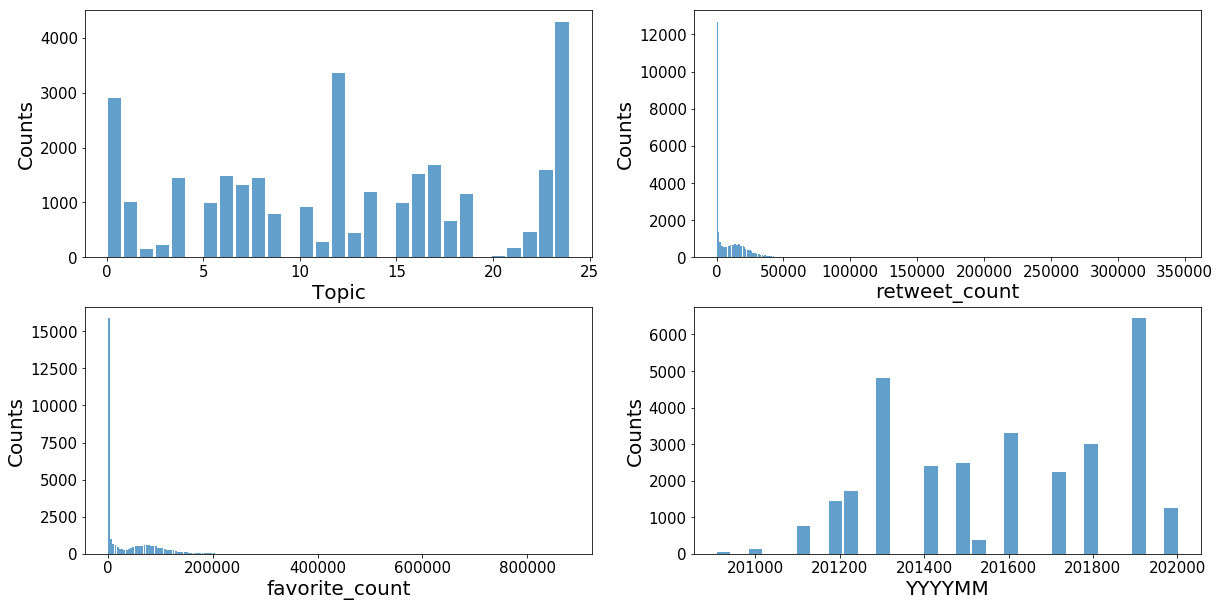

In [9]:
import matplotlib.pyplot as plt

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 2, ncols = 2)

# Specify the features of interest
num_features = ['Topic', 'retweet_count', 'favorite_count','YYYYMM']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts', 'Counts']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(data[num_features[idx]].dropna(), bins='auto',alpha=0.7, rwidth=0.85) 
    ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=15)

##### Step 7: To see if the data is correlated, make some Pearson Ranking charts
The correlation between the variables is low (1 or -1 is high positive or high negative, 0 is low or no correlation)  These results show there is “some” positive correlation but it’s not a high correlation.

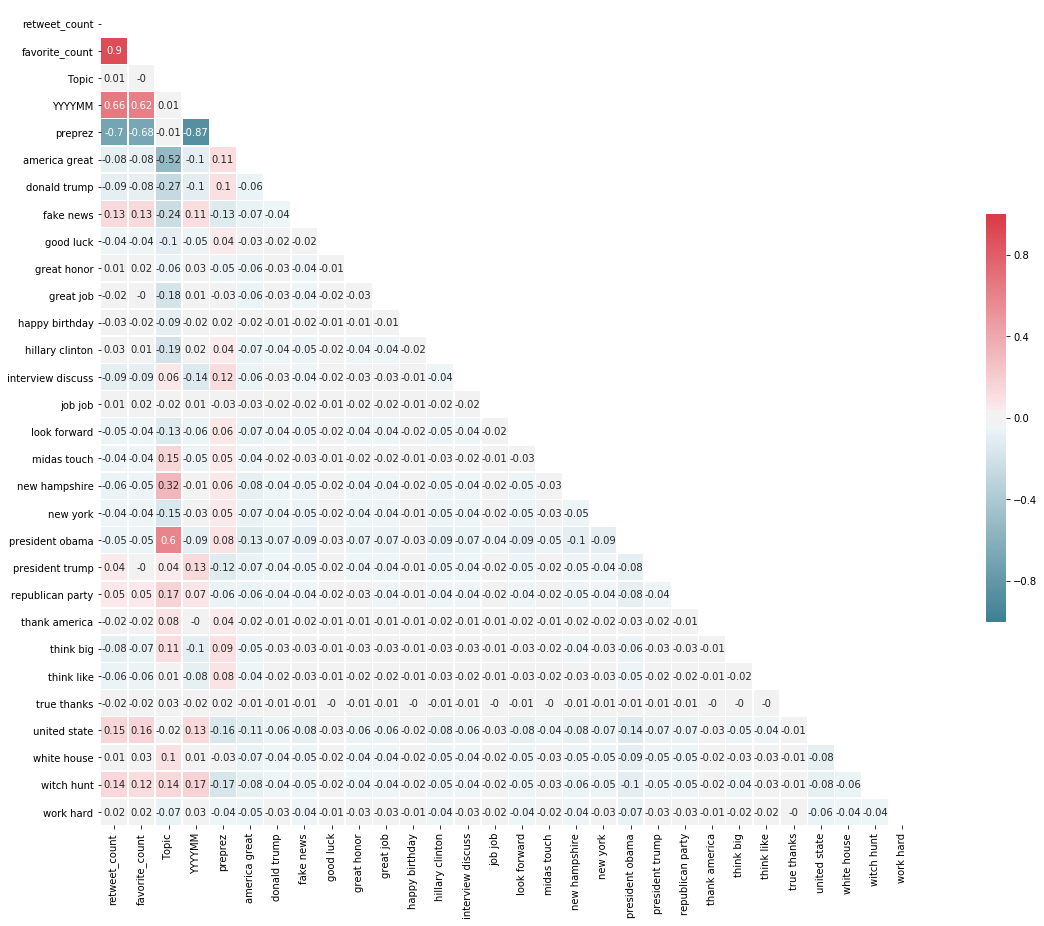

In [10]:
import numpy as np
import seaborn as sns
# apply one hot encoding on the data to pivot the features pn topic
df_one_hot = pd.concat([data,pd.get_dummies(df['topic_top_2'])],axis=1)
df_one_hot = df_one_hot.drop('text', 1)
df_one_hot = df_one_hot.drop('id_str', 1)
df_one_hot = df_one_hot.drop('Date', 1)
df_one_hot = df_one_hot.drop('YYYY', 1)
df_one_hot = df_one_hot.drop('source', 1)

def correlationFunc (df):
    corr = df.corr().round(2)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(25, 15))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

correlationFunc(df_one_hot)

#### Step 8: Filter the data to show specific distibutions

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


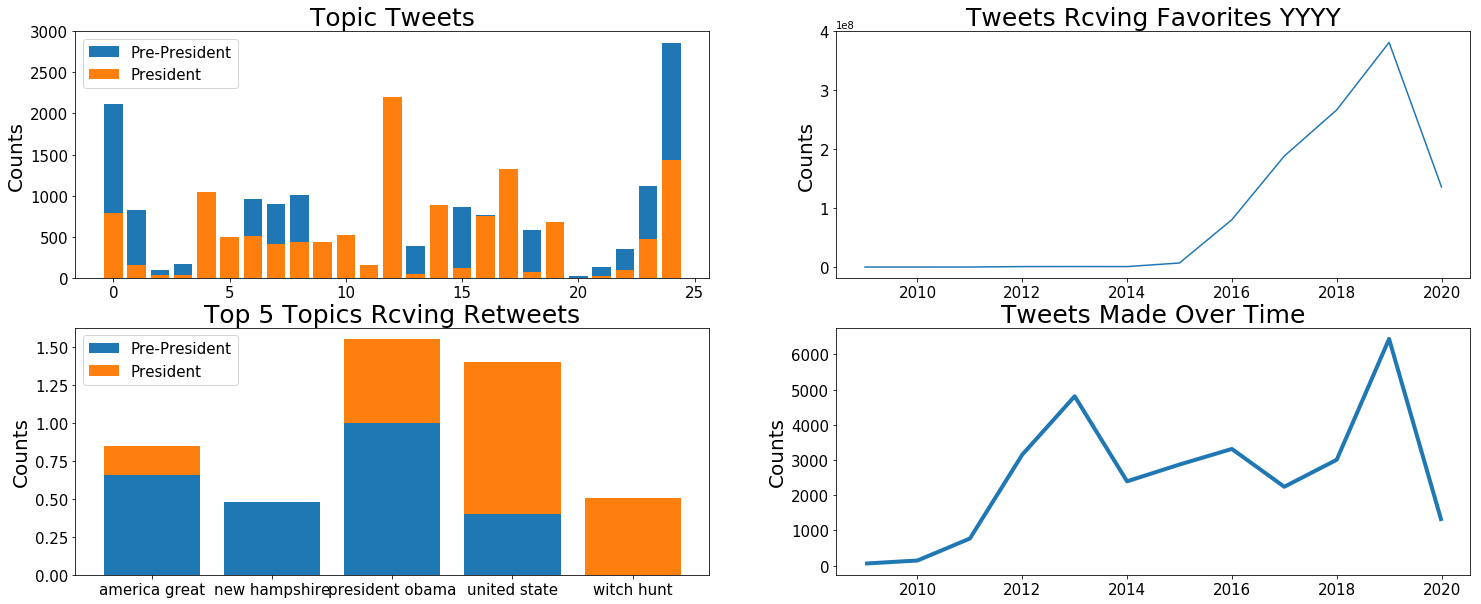

In [11]:
# Dynamically change the default run configure settings or hard code with 20,10 from code example
plt.rcParams['figure.figsize'] = (25, 10)

# subplots utility wrapper makes it convenient to create common layouts of subplots, 
# including the enclosing figure object, in a single call.
# each variable is placed in an axis variable, with a figur variable
fig, axes = plt.subplots(nrows = 2, ncols = 2)

Topics_preprez = data[data['preprez']==1]['Topic'].value_counts()
Topics_postprez = data[data['preprez']==0]['Topic'].value_counts()
# make the bar plot in the first subplot (top left)
p1 = axes[0, 0].bar(Topics_preprez.index, Topics_preprez.values)
p2 = axes[0, 0].bar(Topics_postprez.index, Topics_postprez.values)
axes[0, 0].set_title('Topic Tweets', fontsize=25)
axes[0, 0].set_ylabel('Counts', fontsize=20)
axes[0, 0].tick_params(axis='both', labelsize=15)
axes[0, 0].legend((p1[0], p2[0]), ('Pre-President', 'President'), fontsize = 15)


from sklearn.preprocessing import MinMaxScaler
top_5 = (0,12,17,23,24)

df_pre_top5 = data[(data['preprez']==1) & (data['Topic'].isin(top_5))]
df_post_top5 = data[(data['preprez']==0) & (data['Topic'].isin(top_5))]

df_topic = pd.DataFrame()
df_topic['pre_retweets'] = df_pre_top5.groupby('topic_top_2')['retweet_count'].sum()
df_topic['post_retweets'] = df_post_top5.groupby('topic_top_2')['retweet_count'].sum()

# rescale the data
min_max_scaler = MinMaxScaler()
df_topic[["pre_retweets","post_retweets"]] = min_max_scaler.fit_transform(df_topic[["pre_retweets","post_retweets"]])


###Tweets about Obama Tweets about America Great###
# make the data read to feed into the visualizer  
p3 = axes[1, 0].bar(df_topic["pre_retweets"].index, df_topic[
        "pre_retweets"].values)
p4 = axes[1, 0].bar(df_topic["post_retweets"].index, df_topic[
        "post_retweets"].values, bottom=df_topic["pre_retweets"].values)
axes[1, 0].set_title('Top 5 Topics Rcving Retweets', fontsize=25)
axes[1, 0].set_ylabel('Counts', fontsize=20)
axes[1, 0].tick_params(axis='both', labelsize=15)
axes[1, 0].legend((p3[0], p4[0]), ('Pre-President', 'President'), fontsize = 15)

df_fav = pd.DataFrame()
df_fav['YYYY'] = data.groupby('YYYY')['favorite_count'].sum()

###Tweets Over Time###
# make the data read to feed into the visualizer  
p4 = axes[0, 1].plot(df_fav["YYYY"].index, df_fav["YYYY"].values)
axes[0, 1].set_title('Tweets Rcving Favorites YYYY', fontsize=25)
axes[0, 1].set_ylabel('Counts', fontsize=20)
axes[0, 1].tick_params(axis='both', labelsize=15)

df_tweets = pd.DataFrame()
df_tweets['YYYY'] = data.groupby('YYYY')['id_str'].count()

###Tweets about Obama Tweets about America Great###
# make the data read to feed into the visualizer  
plt.style.use('fivethirtyeight')
p4 = axes[1, 1].plot(df_tweets["YYYY"].index, df_tweets["YYYY"].values)
axes[1, 1].set_title('Tweets Made Over Time', fontsize=25)
axes[1, 1].set_ylabel('Counts', fontsize=20)
axes[1, 1].tick_params(axis='both', labelsize=15)

#### Step 9: Use Parallel Coordinates visualization to compare the distributions of numerical variables between when  that survived and those that did not survive.

['retweet_count', 'favorite_count', 'Topic', 'YYYY']


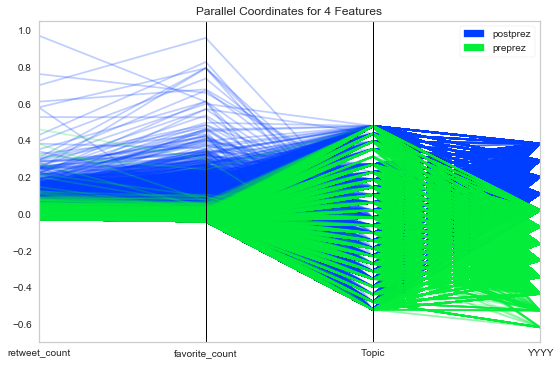

In [10]:
# setup the color for yellowbrick visulizer
# sns_palette is seaborn. 
from yellowbrick.style import set_palette
set_palette('sns_bright')
from yellowbrick.features import ParallelCoordinates
#multi-dimensional feature visualization technique where the vertical axis is duplicated horizontally for each feature
# Specify the features of interest and the classes of the target
df_norm = data.copy()
classes = ['postprez','preprez']
num_features = ['retweet_count', 'favorite_count', 'Topic', 'YYYY']

print(num_features)
# normalize data to 0-1 range using a manual calculation. 
# This could also be done with a variety of libraries, MinMaxScaler()
# without this step, the data graph elements wouldn't be on the same scale.
for feature in num_features:
    df_norm[feature] = (data[feature] - data[feature].mean(skipna=True)
    ) / (data[feature].max(skipna=True) - data[feature].min(skipna=True))

# Extract the numpy arrays from the data frame
X = df_norm[num_features].values
y = data.preprez.values

# Instantiate the visualizer
visualizer = ParallelCoordinates(classes=classes, features=num_features)
visualizer.fit(X, y)      # Fit the data to the visualizer
visualizer.transform(X)   # Transform the data
visualizer.poof() # Draw/show/poof the data

#### Step 10: Eliminate features 

In [12]:
# Use feature selection with a 50 percentile to select most significant features

from sklearn.feature_selection import SelectPercentile, f_classif

target = df_one_hot['preprez']   
features = df_one_hot.drop("preprez", 1)       # feature matrix 
# remove obvious topcis
del features["topic_top_2"]
del features["YYYYMM"]
print(features.shape)
features.astype(int)

fvalue_selector =  SelectPercentile(f_classif, percentile=50)
features_kbest = fvalue_selector.fit(features, target)

cols = features_kbest.get_support(indices=True)
features_df_new = features.iloc[:,cols]

(30440, 28)


In [12]:
print(features_df_new.head())

   retweet_count  favorite_count  america great  donald trump  fake news  \
0          25848           80837              0             0          0   
1          20027           64121              0             0          0   
2           9718           33916              0             0          1   
3          28072           86435              1             0          0   
4           7597           31886              0             0          0   

   interview discuss  new hampshire  president obama  president trump  \
0                  0              0                0                0   
1                  0              0                0                0   
2                  0              0                0                0   
3                  0              0                0                0   
4                  0              0                0                0   

   republican party  think big  think like  united state  witch hunt  
0                 0          0   

#### Step 11: Log Transformation is a good method to use on highly skewed data.  

In [13]:
# run both skewed features through a log tranformation
features_df_new['retweet_log1'] = features_df_new.retweet_count.apply(
        lambda x: np.log1p(x))
features_df_new['favorite_log1'] = features_df_new.favorite_count.apply(
        lambda x: np.log1p(x))
# remove non-transformed data
del features_df_new["retweet_count"]
del features_df_new["favorite_count"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
print(features_df_new.describe())
print(features.describe())

       america great  donald trump     fake news  interview discuss  \
count   30440.000000  30440.000000  30440.000000       30440.000000   
mean        0.095269      0.032852      0.047372           0.032227   
std         0.293591      0.178251      0.212437           0.176606   
min         0.000000      0.000000      0.000000           0.000000   
25%         0.000000      0.000000      0.000000           0.000000   
50%         0.000000      0.000000      0.000000           0.000000   
75%         0.000000      0.000000      0.000000           0.000000   
max         1.000000      1.000000      1.000000           1.000000   

       new hampshire  president obama  president trump  republican party  \
count   30440.000000     30440.000000     30440.000000      30440.000000   
mean        0.052201         0.140966         0.039290          0.037648   
std         0.222436         0.347992         0.194288          0.190346   
min         0.000000         0.000000         0.000000  

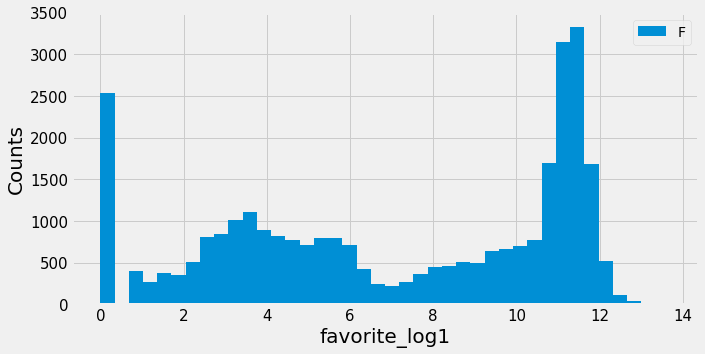

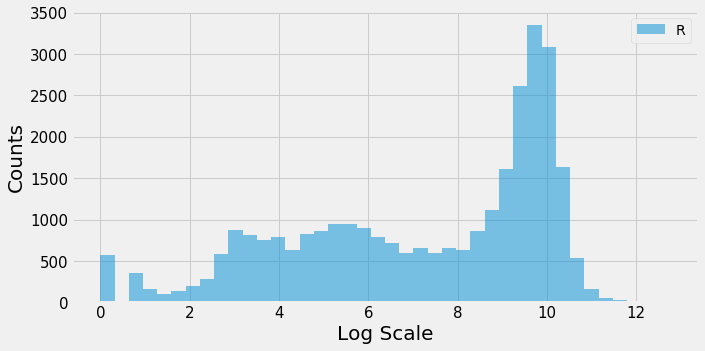

In [14]:
# plot both newly transformed features
plt.rcParams['figure.figsize'] = (10, 5)

plt.hist(features_df_new['favorite_log1'], bins=40)
plt.xlabel('favorite_log1', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(axis='both', labelsize=15)
plt.legend('Favorite Tweets')
plt.show()

plt.hist(features_df_new['retweet_log1'], bins=40, alpha=.5)
plt.xlabel('Log Scale', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(axis='both', labelsize=15)
plt.legend('Retweeted')
plt.show()

#### Step 12: convert categorical data to numbers

This step was completed on step 7

In [15]:
data_model_X = features_df_new.copy()

In [18]:
print(data_model_X.head())

   america great  donald trump  fake news  interview discuss  new hampshire  \
0              0             0          0                  0              0   
1              0             0          0                  0              0   
2              0             0          1                  0              0   
3              1             0          0                  0              0   
4              0             0          0                  0              0   

   president obama  president trump  republican party  think big  think like  \
0                0                0                 0          0           0   
1                0                0                 0          0           0   
2                0                0                 0          0           0   
3                0                0                 0          0           0   
4                0                0                 0          0           0   

   united state  witch hunt  retweet_log1  f

In [16]:
print(target.shape[0])
print(data_model_X.shape[0])

30440
30440


### NEW - update the split with k-fold

per recommendation from student, I attempted to use a kFold method for my training set. I ended up with zero false postiives and false negatives. Which mean it either was a robust model, or overfitted. I think the latter. 

In [17]:
#data_model_np = data_model_X.copy()

In [18]:
#X = data_model_np.values
#y = target.values

In [19]:
#from sklearn.model_selection import KFold
#kf = KFold(n_splits=2)
#kf.get_n_splits(y)
#print(kf) 
#KFold(n_splits=2, random_state=None, shuffle=False)

#for train_index, test_index in kf.split(y):
#    print('train: ', train_index, 'test: ', test_index)
#    X_train, X_val = X[train_index], X[test_index]
#    y_train, y_val = y[train_index], y[test_index]

KFold(n_splits=2, random_state=None, shuffle=False)
train:  [15220 15221 15222 ... 30437 30438 30439] test:  [    0     1     2 ... 15217 15218 15219]
train:  [    0     1     2 ... 15217 15218 15219] test:  [15220 15221 15222 ... 30437 30438 30439]


In [25]:
from sklearn.model_selection import train_test_split

# split the data, 30% of the records will be assigned to the test data, 70% to the training set (val)
X_train, X_val, y_train, y_val = train_test_split(data_model_X, target, test_size =0.3, random_state=11)

In [26]:
# number of samples in each set
print("No. of samples in training set: ", X_train.shape)
print("No. of samples in validation set:", X_val.shape)

No. of samples in training set:  (21308, 14)
No. of samples in validation set: (9132, 14)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


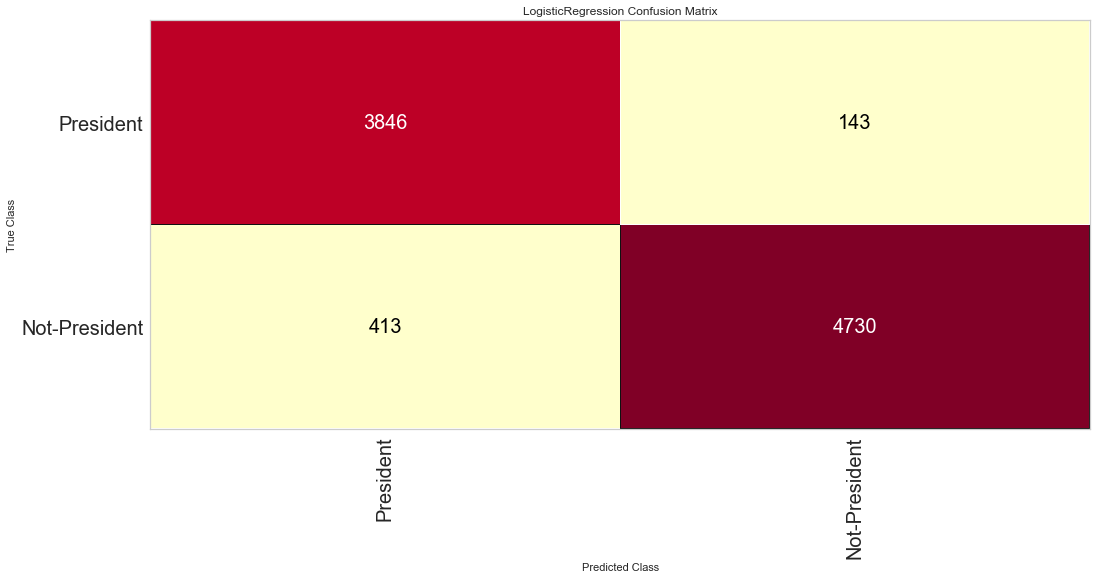

In [27]:
# Step 15 - Eval Metrics
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

# Instantiate the classification model 
model = LogisticRegression()

#The ConfusionMatrix visualizer taxes a model
# call the binary classifiers
classes = ['President','Not-President']
# yellow brick confusion matrix called with the instantiated model object
# classes are the binary classifiers
cm = ConfusionMatrix(model, classes=classes, percent=False)

#Fit fits the LogisticRegression model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

#How did we do?
cm.poof()

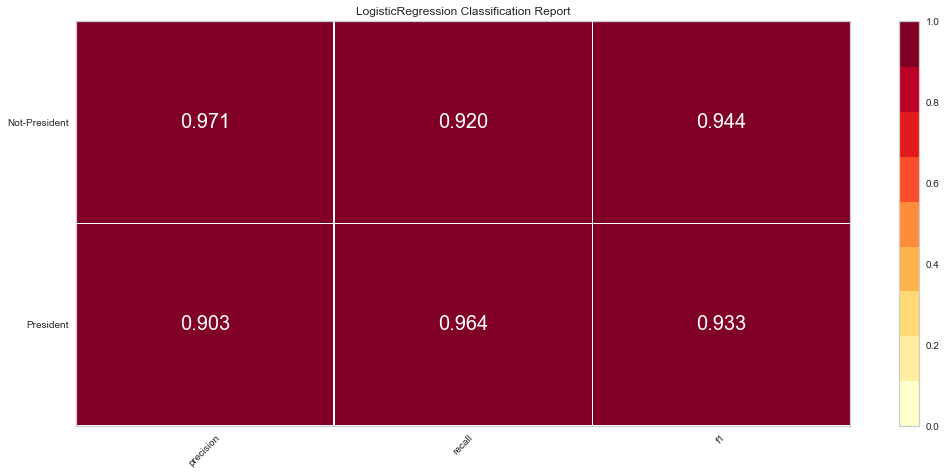

In [28]:
# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer with the LogisticRegression Model to obtain the metrics for evaluation
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

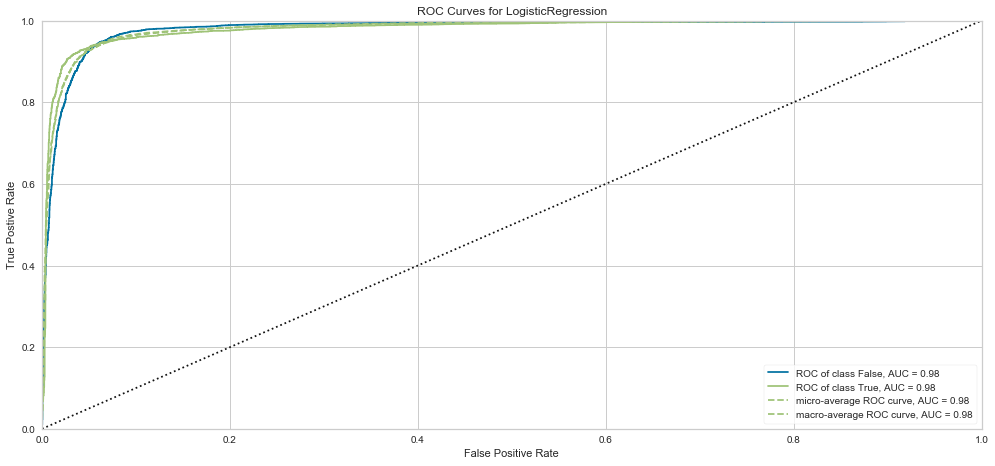

In [29]:
# ROC and AUC
#Instantiate the visualizer to the Logistic Regression to visulizr Receiving Operating Characteristic (ROC)
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data

g = visualizer.poof()

That was too easy... let's see if we can predict byt he topic being Tweeted

In [31]:
target = df_one_hot['preprez']   
features = df_one_hot.drop("preprez", 1)       # feature matrix 
# remove obvious topcis
del features["topic_top_2"]
del features["YYYYMM"]
del features["retweet_count"]
del features["favorite_count"]
del features["Topic"]

In [32]:
from sklearn.model_selection import train_test_split

# split the data, 30% of the records will be assigned to the test data, 70% to the training set (val)
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size =0.3, random_state=11)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


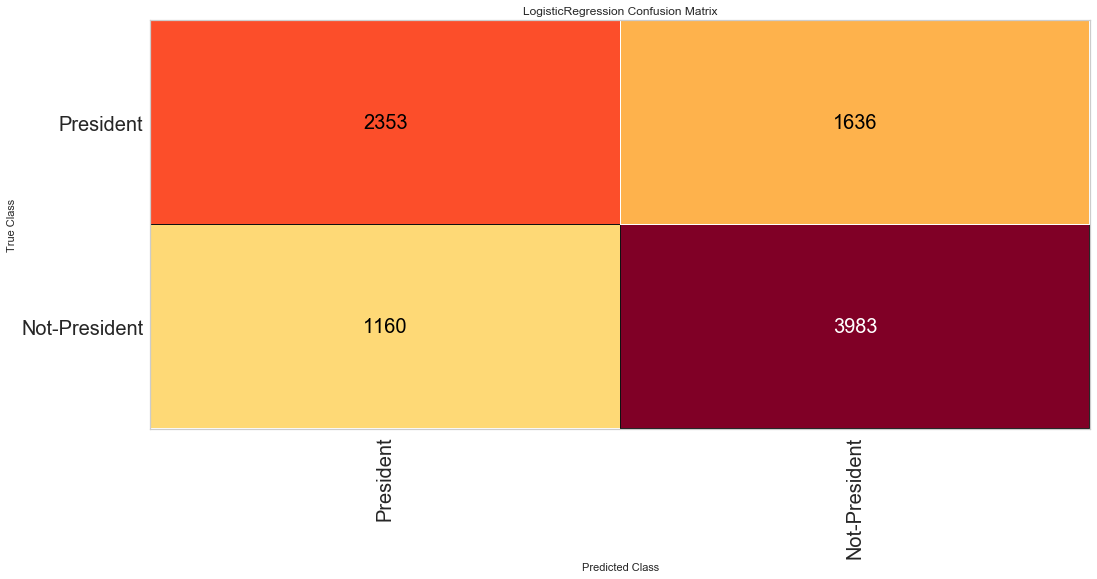

In [33]:
# Step 15 - Eval Metrics
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

# Instantiate the classification model 
model = LogisticRegression()

#The ConfusionMatrix visualizer taxes a model
# call the binary classifiers
classes = ['President','Not-President']
# yellow brick confusion matrix called with the instantiated model object
# classes are the binary classifiers
cm = ConfusionMatrix(model, classes=classes, percent=False)

#Fit fits the LogisticRegression model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

#How did we do?
cm.poof()

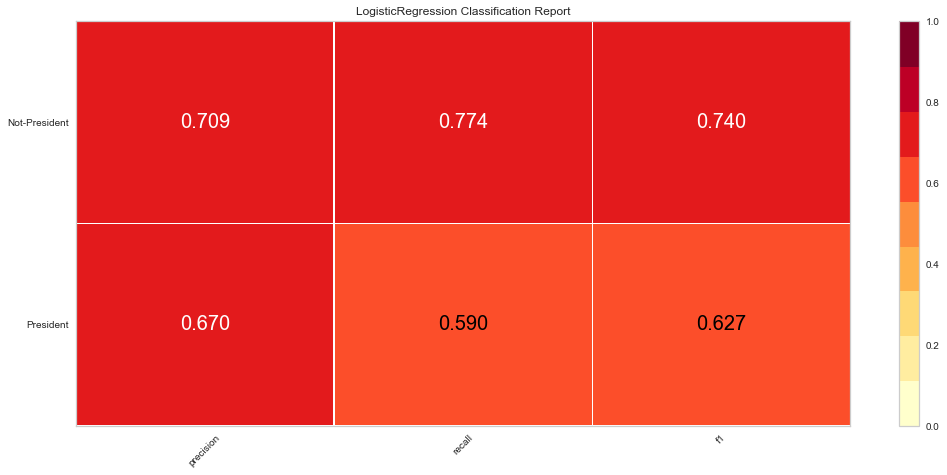

In [34]:
# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer with the LogisticRegression Model to obtain the metrics for evaluation
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

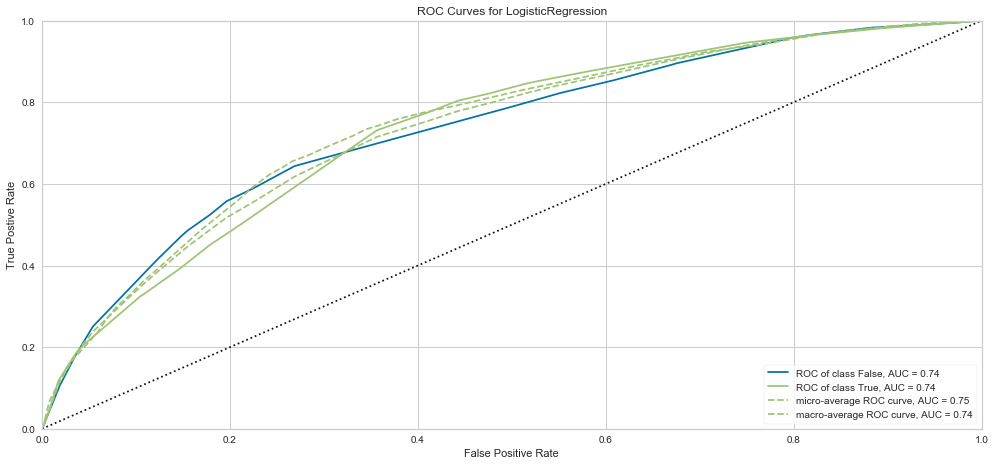

In [35]:
# ROC and AUC
#Instantiate the visualizer to the Logistic Regression to visulizr Receiving Operating Characteristic (ROC)
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data

g = visualizer.poof()